In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_B.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_B'], dtype=object)

In [6]:
data_std.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_B'] 
X = data_std.drop(['Coeff_B','Name'], axis=1)

### Using CV technique

RF
R2:  0.913585090041637
RMSE:  0.293964130394106
---------------------------------------
GB
R2:  0.9032923740376834
RMSE:  0.31097849758836477
---------------------------------------
LR
R2:  -2.1334339472331592e+24
RMSE:  1460627929088.4312
---------------------------------------
RR
R2:  0.32314700617947634
RMSE:  0.8227107595142558
---------------------------------------
LASSO
R2:  0.9179374953183495
RMSE:  0.2864655383840272
---------------------------------------
gpr1
R2:  0.8783848879694313
RMSE:  0.34873358316997344
---------------------------------------
gpr2
R2:  0.925995961795524
RMSE:  0.27203683244089577
---------------------------------------
gpr3
R2:  0.8869332594446679
RMSE:  0.3362539822148312
---------------------------------------
gpr4
R2:  0.8869333046511664
RMSE:  0.33625391499406154
---------------------------------------
gpr5
R2:  0.9197072901026302
RMSE:  0.28335968290737795
---------------------------------------
gpr6
R2:  0.8730178879936044
RMSE:  0.35634549528

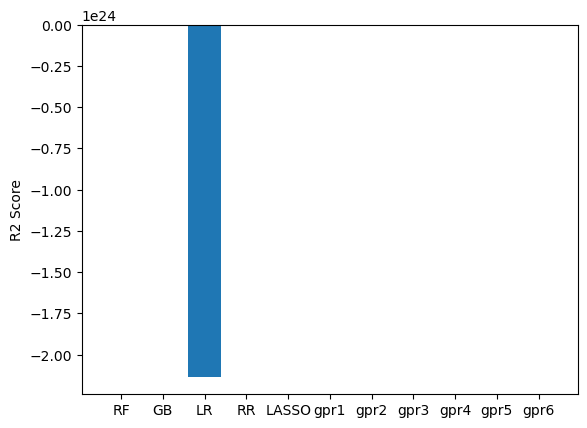

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature       Score
14     X_EA  117.183506
2       X_Z   99.651797
22   X_Rvdw   87.228516
11   X_IEII   71.960813
20   A_Rvdw   51.441835
6     A_IEI   35.525431
18   A_ChiA   32.735412
32     B_Hf   19.545691
5       X_G   17.821495
15   A_ChiP   15.809368
26     B_MP   15.701586
24     B_Ra   14.704776
25     A_MP   12.747613
12     A_EA   11.971525
1       B_Z   11.111687
0       A_Z   11.021670
35  X_Kappa    8.465232
36    A_CvM    8.222969
33  A_Kappa    7.662938
30     B_MV    7.438268
31     X_MV    7.201300
34  B_Kappa    6.859575
38      A_B    4.970973
37    B_CvM    4.905911
28    B_Rho    4.575892
3       A_G    4.430506
13     B_EA    3.575124
21   B_Rvdw    3.474726
8     X_IEI    2.907641
23     B_Rc    2.869415


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'X_G', 'A_ChiP', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'B_Z',
       'A_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_MV', 'X_MV', 'B_Kappa',
       'A_B', 'B_CvM', 'B_Rho', 'A_G', 'B_EA', 'B_Rvdw', 'X_IEI', 'B_Rc',
       'B_ChiP', 'B_IEII', 'B_G', 'A_Rho', 'B_IEI', 'X_Rho',
       'B_MendeleevNo', 'B_ChiA', 'B_B', 'X_ChiP'], dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9143932595829243
RMSE:  0.2925862956754395
---------------------------------------
GB
R2:  0.889744399733473
RMSE:  0.3320475873523659
---------------------------------------
LR
R2:  -1.3005805000591255e+23
RMSE:  360635619435.8962
---------------------------------------
RR
R2:  0.2333364962686083
RMSE:  0.8755932296057295
---------------------------------------
LASSO
R2:  0.9180342541673691
RMSE:  0.28629660464740225
---------------------------------------
gpr1
R2:  0.6846667905604383
RMSE:  0.5615453761180494
---------------------------------------
gpr2
R2:  0.9243906131819042
RMSE:  0.27497161093119377
---------------------------------------
gpr3
R2:  0.8818978751784234
RMSE:  0.3436598970225891
---------------------------------------
gpr4
R2:  0.8818979391483714
RMSE:  0.3436598039509837
---------------------------------------
gpr5
R2:  0.9176420941772678
RMSE:  0.28698067151418427
---------------------------------------
gpr6
R2:  0.8771231268226845
RMSE:  0.3505379767975

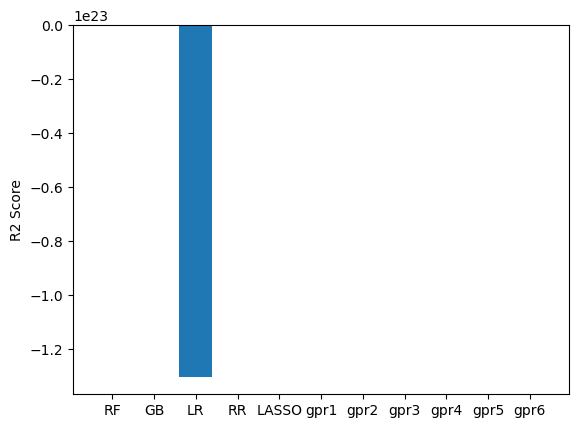

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'X_G', 'A_ChiP', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'B_Z',
       'A_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_MV', 'X_MV', 'B_Kappa',
       'A_B', 'B_CvM', 'B_Rho', 'A_G', 'B_EA', 'B_Rvdw', 'X_IEI', 'B_Rc'],
      dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.918822585580537
RMSE:  0.28491650429461435
---------------------------------------
GB
R2:  0.9162476264863512
RMSE:  0.28940002334769915
---------------------------------------
LR
R2:  -3.282924273423875e+20
RMSE:  18118841777.066975
---------------------------------------
RR
R2:  0.8833795699243824
RMSE:  0.3414973353858235
---------------------------------------
LASSO
R2:  0.917965486173445
RMSE:  0.28641667868082504
---------------------------------------
gpr1
R2:  0.9134447361768774
RMSE:  0.29420275971364146
---------------------------------------
gpr2
R2:  0.9352514483154313
RMSE:  0.25445736712575007
---------------------------------------
gpr3
R2:  0.8933391239825316
RMSE:  0.32658976716588717
---------------------------------------
gpr4
R2:  0.8933391286558228
RMSE:  0.3265897600112062
---------------------------------------
gpr5
R2:  0.9310794278621001
RMSE:  0.2625272788452657
---------------------------------------
gpr6
R2:  0.8998832208495033
RMSE:  0.31641235619

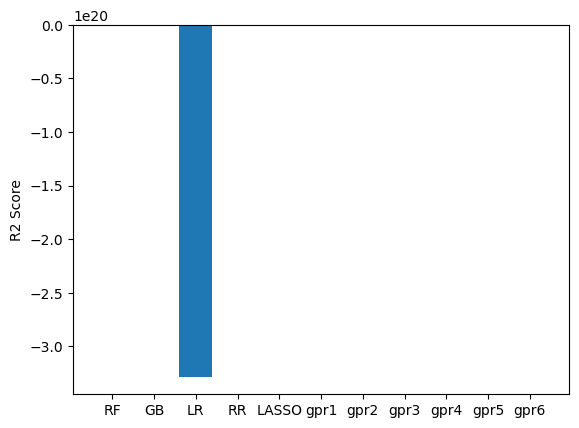

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'X_G', 'A_ChiP', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'B_Z',
       'A_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_MV'], dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.913713244689431
RMSE:  0.2937460728428024
---------------------------------------
GB
R2:  0.9153202392216404
RMSE:  0.29099787074540534
---------------------------------------
LR
R2:  0.8799562949632198
RMSE:  0.3464732385578721
---------------------------------------
RR
R2:  0.8803951351536365
RMSE:  0.34583936277752336
---------------------------------------
LASSO
R2:  0.9056238147677516
RMSE:  0.3072070722367056
---------------------------------------
gpr1
R2:  0.9044714531233407
RMSE:  0.30907692711792534
---------------------------------------
gpr2
R2:  0.9146910011864934
RMSE:  0.29207704259922
---------------------------------------
gpr3
R2:  0.7969188924647734
RMSE:  0.4506452124845294
---------------------------------------
gpr4
R2:  0.8837894604977165
RMSE:  0.3408966698316127
---------------------------------------
gpr5
R2:  0.925454898687233
RMSE:  0.27302948799125537
---------------------------------------
gpr6
R2:  0.9136043225354172
RMSE:  0.29393141625995467
-

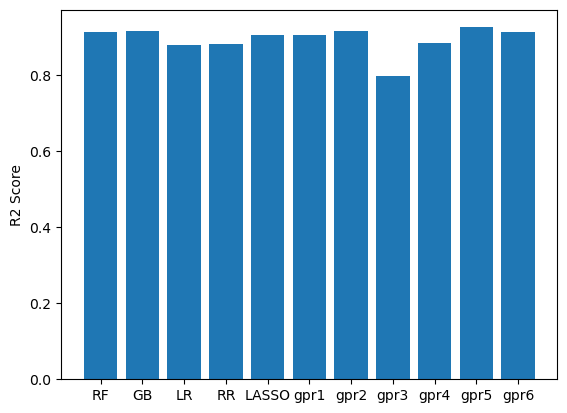

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'X_G', 'A_ChiP'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9168166868101244
RMSE:  0.28841517503397013
---------------------------------------
GB
R2:  0.8724705486555726
RMSE:  0.3571126591769429
---------------------------------------
LR
R2:  0.8980023718869586
RMSE:  0.31937067509876566
---------------------------------------
RR
R2:  0.8980428068814663
RMSE:  0.3193073646481298
---------------------------------------
LASSO
R2:  0.9006250061658067
RMSE:  0.3152379955433566
---------------------------------------
gpr1
R2:  0.9062834839763142
RMSE:  0.3061315338603422
---------------------------------------
gpr2
R2:  0.9033814780829911
RMSE:  0.31083520057581787
---------------------------------------
gpr3
R2:  0.22772582861700985
RMSE:  0.8787913127603106
---------------------------------------
gpr4
R2:  0.227725657327026
RMSE:  0.8787914102180187
---------------------------------------
gpr5
R2:  0.8687288104682097
RMSE:  0.3623136618067145
---------------------------------------
gpr6
R2:  0.9075957815576167
RMSE:  0.3039806218205090

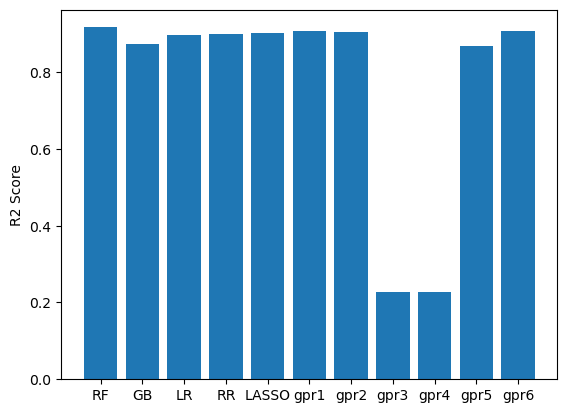

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_B.csv', encoding='cp1252')

In [24]:
data_mm.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_B'] 
X = data_mm.drop(['Coeff_B','Name'], axis=1)

### Using CV technique

RF
R2:  0.9128997334194577
RMSE:  0.07973413248689058
---------------------------------------
GB
R2:  0.9018304352449279
RMSE:  0.08464922066686734
---------------------------------------
LR
R2:  -8.622484643627052e+23
RMSE:  250871164716.43918
---------------------------------------
RR
R2:  0.8770568891550191
RMSE:  0.09472980215867824
---------------------------------------
LASSO
R2:  0.8297273826771018
RMSE:  0.11148256109202896
---------------------------------------
gpr1
R2:  0.7832578396259131
RMSE:  0.12577844761346432
---------------------------------------
gpr2
R2:  0.9261387492557452
RMSE:  0.07342481485881779
---------------------------------------
gpr3
R2:  0.22996460846059574
RMSE:  0.2370772464366353
---------------------------------------
gpr4
R2:  0.8501010348793168
RMSE:  0.10460052121887224
---------------------------------------
gpr5
R2:  0.9209779138059891
RMSE:  0.0759466770809758
---------------------------------------
gpr6
R2:  0.8971053358372935
RMSE:  0.0866624

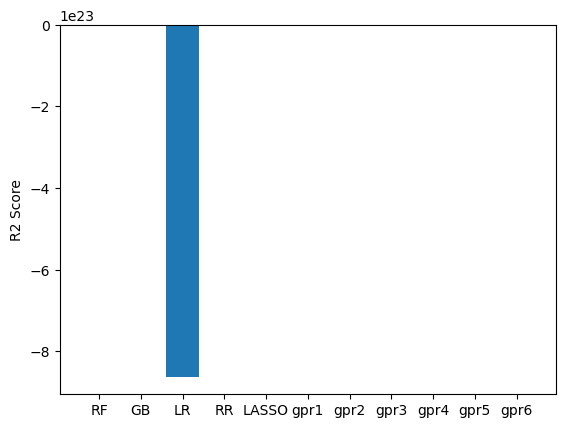

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature       Score
14     X_EA  117.183506
2       X_Z   99.651797
22   X_Rvdw   87.228516
20   A_Rvdw   51.441835
6     A_IEI   35.525431
18   A_ChiA   31.410595
32     B_Hf   19.545691
5       X_G   17.821495
11   X_IEII   15.947207
15   A_ChiP   15.809368
26     B_MP   15.701586
24     B_Ra   14.704776
25     A_MP   12.747613
12     A_EA   11.971525
1       B_Z   11.111687
0       A_Z   11.021670
29    X_Rho   10.709519
35  X_Kappa    8.465232
36    A_CvM    8.222969
19   B_ChiA    7.956686
33  A_Kappa    7.662938
30     B_MV    7.438268
31     X_MV    7.201300
34  B_Kappa    6.859575
38      A_B    4.970973
37    B_CvM    4.619891
3       A_G    4.430506
28    B_Rho    4.070215
13     B_EA    3.575124
21   B_Rvdw    3.474726


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'B_Hf',
       'X_G', 'X_IEII', 'A_ChiP', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'B_Z',
       'A_Z', 'X_Rho', 'X_Kappa', 'A_CvM', 'B_ChiA', 'A_Kappa', 'B_MV',
       'X_MV', 'B_Kappa', 'A_B', 'B_CvM', 'A_G', 'B_Rho', 'B_EA',
       'B_Rvdw', 'X_IEI', 'B_Rc', 'B_ChiP', 'B_G', 'A_Rho', 'B_IEII',
       'B_IEI', 'B_MendeleevNo', 'B_B', 'X_ChiP'], dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9142425420354445
RMSE:  0.07911712201791266
---------------------------------------
GB
R2:  0.8978163284133458
RMSE:  0.08636251537505632
---------------------------------------
LR
R2:  -1.0061862839982429e+21
RMSE:  8569860010.92329
---------------------------------------
RR
R2:  0.7373945246865108
RMSE:  0.13844791500754303
---------------------------------------
LASSO
R2:  0.8297319978403244
RMSE:  0.11148105023928456
---------------------------------------
gpr1
R2:  0.5244280236966319
RMSE:  0.18631278554935993
---------------------------------------
gpr2
R2:  0.9228972759811517
RMSE:  0.07501867551541978
---------------------------------------
gpr3
R2:  0.8331513331487009
RMSE:  0.11035598761831376
---------------------------------------
gpr4
R2:  0.8331513381495024
RMSE:  0.11035598596451456
---------------------------------------
gpr5
R2:  0.9196404741238937
RMSE:  0.07658667484004379
---------------------------------------
gpr6
R2:  0.9004875773472638
RMSE:  0.0852262

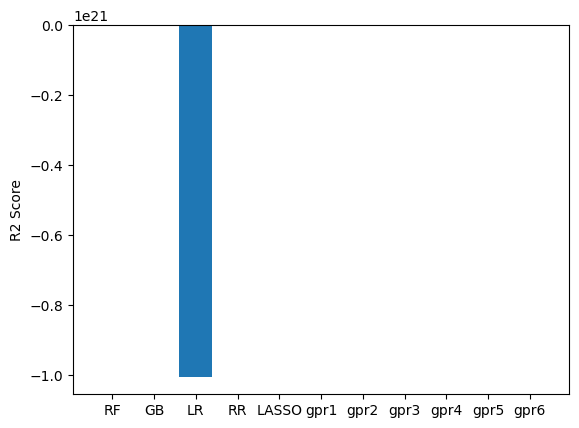

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'B_Hf',
       'X_G', 'X_IEII', 'A_ChiP', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'B_Z',
       'A_Z', 'X_Rho', 'X_Kappa', 'A_CvM', 'B_ChiA', 'A_Kappa', 'B_MV',
       'X_MV', 'B_Kappa', 'A_B', 'B_CvM', 'A_G', 'B_Rho', 'B_EA',
       'B_Rvdw'], dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9167080329877629
RMSE:  0.0779715361546092
---------------------------------------
GB
R2:  0.9065792639402765
RMSE:  0.08257644339971941
---------------------------------------
LR
R2:  -4.3267754434233736e+20
RMSE:  5619746291.915983
---------------------------------------
RR
R2:  0.8815645661552155
RMSE:  0.09297696357307358
---------------------------------------
LASSO
R2:  0.8297320120142445
RMSE:  0.11148104559917747
---------------------------------------
gpr1
R2:  0.8437151275634938
RMSE:  0.10680534879276156
---------------------------------------
gpr2
R2:  0.9225533955368517
RMSE:  0.07518578216052745
---------------------------------------
gpr3
R2:  0.8359974513088158
RMSE:  0.10941070840031664
---------------------------------------
gpr4
R2:  0.835997453579039
RMSE:  0.10941070764305177
---------------------------------------
gpr5
R2:  0.9197910569120781
RMSE:  0.0765148847030102
---------------------------------------
gpr6
R2:  0.9132660324365462
RMSE:  0.079566295

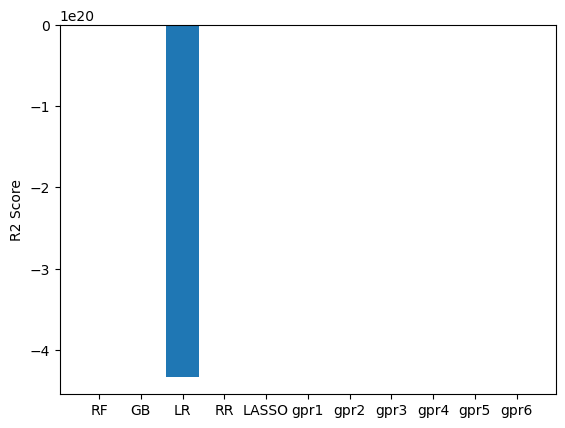

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'B_Hf',
       'X_G', 'X_IEII', 'A_ChiP', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'B_Z',
       'A_Z', 'X_Rho', 'X_Kappa', 'A_CvM', 'B_ChiA'], dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9016675306172841
RMSE:  0.08471942589696775
---------------------------------------
GB
R2:  0.8852743464292967
RMSE:  0.0915092090436235
---------------------------------------
LR
R2:  0.8893473476042767
RMSE:  0.08987014567060853
---------------------------------------
RR
R2:  0.8841258692527687
RMSE:  0.09196610130330711
---------------------------------------
LASSO
R2:  0.8297320963926618
RMSE:  0.11148101797626533
---------------------------------------
gpr1
R2:  0.8874792475995728
RMSE:  0.09062558960629859
---------------------------------------
gpr2
R2:  0.9027882644984488
RMSE:  0.08423525203187018
---------------------------------------
gpr3
R2:  0.7561376709038834
RMSE:  0.13341568489165836
---------------------------------------
gpr4
R2:  0.7561376375607203
RMSE:  0.1334156940125849
---------------------------------------
gpr5
R2:  0.9260454316396677
RMSE:  0.07347118332536874
---------------------------------------
gpr6
R2:  0.9201587929277697
RMSE:  0.07633928331

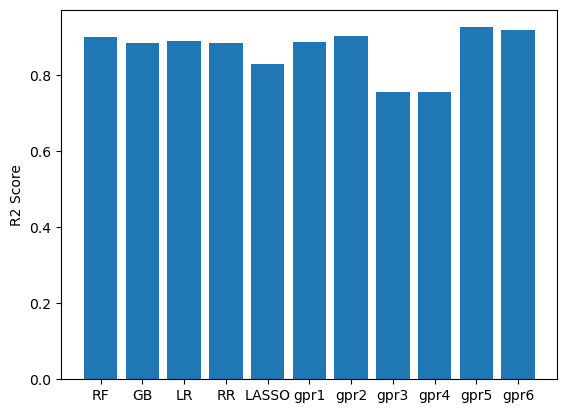

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'B_Hf',
       'X_G', 'X_IEII', 'A_ChiP'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9232469966067488
RMSE:  0.07484834822932782
---------------------------------------
GB
R2:  0.88245979808286
RMSE:  0.09262489902507616
---------------------------------------
LR
R2:  0.8999535759540451
RMSE:  0.08545457458105331
---------------------------------------
RR
R2:  0.8995395290853131
RMSE:  0.08563122090894665
---------------------------------------
LASSO
R2:  0.8037860160524454
RMSE:  0.11967391789582478
---------------------------------------
gpr1
R2:  0.8998124996743555
RMSE:  0.08551480345301612
---------------------------------------
gpr2
R2:  0.89857056825836
RMSE:  0.08604319481050728
---------------------------------------
gpr3
R2:  -2.935129933171473
RMSE:  0.5359374058029415
---------------------------------------
gpr4
R2:  -1.7940777621878752
RMSE:  0.4515998362097494
---------------------------------------
gpr5
R2:  0.8491061563788547
RMSE:  0.10494706367457608
---------------------------------------
gpr6
R2:  0.9068028262388355
RMSE:  0.08247757863955

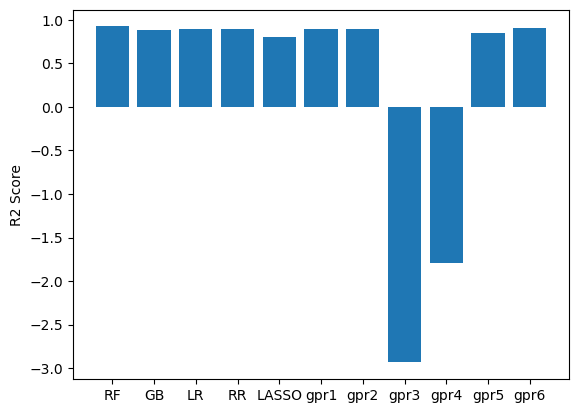

In [40]:
run_models()